<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/PNSPV/notebooky/keras_2020/cv08_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8. cvičenie - Vizualizácia

Na dnešnom cvičení si prejdeme metódy vizualizácie dát. Najprv si zobrazíme dôležité časti siete. Potom si zobrazíme ako fungujú filtre.

Toto spravíme s predtrénovaným modelom.

In [1]:
import keras
import cv2
import numpy as np
from keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

Keďže v tf 2.0 je výpočet gradientu v tzv. eager móde pre jednotlivé vrstvy siete zložitejší, tak si nastavím tf aby nepoužíval eager mód.

In [4]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [5]:
resnet = keras.applications.resnet.ResNet50()

Načítame si testovacie obrázky a zmeníme ich rozmery.

In [6]:
test_imgs = []
!wget https://pixnio.com/free-images/2017/06/08/2017-06-08-13-53-59-900x576.jpg
test_imgs.append(cv2.resize(cv2.imread('2017-06-08-13-53-59-900x576.jpg'),(224,224)))
!wget https://storage.needpix.com/rsynced_images/diver-1881751_1280.jpg
test_imgs.append(cv2.resize(cv2.imread('diver-1881751_1280.jpg'),(224,224)))
!wget https://cdn.pixabay.com/photo/2017/09/22/23/24/white-stork-2777489_960_720.jpg
test_imgs.append(cv2.resize(cv2.imread('white-stork-2777489_960_720.jpg'),(224,224)))
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Croatia_police_van_%2804%29.JPG/800px-Croatia_police_van_%2804%29.JPG
test_imgs.append(cv2.resize(cv2.imread('800px-Croatia_police_van_(04).JPG'),(224,224)))


--2020-11-29 22:37:38--  https://pixnio.com/free-images/2017/06/08/2017-06-08-13-53-59-900x576.jpg
Resolving pixnio.com (pixnio.com)... 170.249.203.179
Connecting to pixnio.com (pixnio.com)|170.249.203.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311968 (305K) [image/jpeg]
Saving to: ‘2017-06-08-13-53-59-900x576.jpg.1’

2017-06-08-13-53-59 100%[===================>] 304.66K   951KB/s    in 0.3s    

2020-11-29 22:37:38 (951 KB/s) - ‘2017-06-08-13-53-59-900x576.jpg.1’ saved [311968/311968]

--2020-11-29 22:37:39--  https://storage.needpix.com/rsynced_images/diver-1881751_1280.jpg
Resolving storage.needpix.com (storage.needpix.com)... 89.40.7.139
Connecting to storage.needpix.com (storage.needpix.com)|89.40.7.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282433 (276K) [application/octet-stream]
Saving to: ‘diver-1881751_1280.jpg.1’

diver-1881751_1280. 100%[===================>] 275.81K   188KB/s    in 1.5s    

2020-11-29 

Pred vstupom do siete ešte aplikujeme predspracovanie, aby to korešpondovalo s natrénovanou sieťou. **Treba si taktiež dať pozor na to či je formát v BGR ako to má OpenCV, alebo RGB!**

In [7]:
pred = resnet.predict(preprocess_input(test_imgs[0])[None, :, :, :])
print(np.argmax(pred[0]))
print(decode_predictions(pred)[0])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
820
[('n04310018', 'steam_locomotive', 0.9962769), ('n03393912', 'freight_car', 0.0017455405), ('n03895866', 'passenger_car', 0.0016961105), ('n03272562', 'electric_locomotive', 0.00017318252), ('n02950826', 'cannon', 6.8077155e-05)]


## DeepDream

V tejto časti si predvedieme základný princíp metódy DeepDream, ktorá núti sieť "halucinovať" silnejšie príznaky. Tu si ukážeme len základný algoritmus. V skutočnosti sa používa napríklad vo viacerych škálach a medzi jednotlivými sa obrázok ešte posúva. Plnú verziu nájdete v [notebooku pre DOD 2019](https://github.com/kocurvik/edu/blob/master/DOD/DOD_2019_DeepDream.ipynb), alebo v [originálnej verzii](https://research.google.com/seedbank/seed/deepdream).

Princíp DeepDreamu je jednoduchý. Vyberieme časť siete (stačí aj jeden kanál nejakej feature mapy) a jeho hodnotu (jej štvorec) si označíme ako cenovú funkciu. Potom spočítame gradient obrazu voči tejto cene. To samozrejme framework dokáže jednoducho. Vďaka gradientu potom môžme modifikovať obraz tak aby sa naša cenová funkcia zväčšovala. Tým dostaneme obraz, ktorý aktivuje danú časť siete čo najviac.

Na to aby to fungovalo budeme potrebovať znova volať backend. Užitočná bude funkcia K.gradients. Takisto budeme potrebovať vedieť nájsť časti siete ktoré nás zaujímajú. To docielime pomocou model.layers a vstupný obraz dostaneme pomocou model.input.



In [8]:
import keras.backend as K

Tu je vytvorená funkcia inverzná k preprocess_image na to aby sme mohli konvertovať obrázky spätne a zobraziť ich.

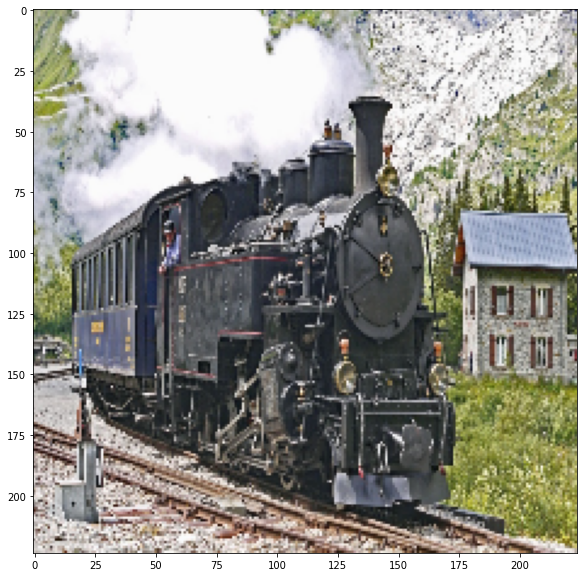

In [9]:
def deprocess_image(img):
  mean = np.array([103.939, 116.779, 123.68])
  img += mean
  img = np.clip(img, 0, 255)
  return np.uint8(img[:,:,::-1])

img = preprocess_input(test_imgs[0])
img = deprocess_image(img)
plt.figure(figsize = (10,10))
plt.imshow(img[:,:,::-1])
plt.show()

Toto je kód k základnému DeepDreamu. Všimnite si, že iterujeme tak aby sa loss zvyšovala. Pri tejto implementácii je dôležité uveodmiť si, že vhodné nastavenie eta úzko súvisí s tým ako je nastavená loss. Ak by loss bola napr. súčet a nie priemer, tak by sme zvolili nižšie eta.

In [10]:
def deep_dream(input_img, model, layer_name, channel_index, eta, steps):
  model_input = model.input
  layer_dict = dict([(layer.name, layer) for layer in model.layers])
  if layer_name not in layer_dict:
    raise ValueError('Layer ' + layer_name + ' not found in model.')
  layer = layer_dict[layer_name].output
  if layer.shape[3] < channel_index:
    raise ValueError('Layer ' + layer_name + ' has only {} channels.'.format(layer.shape[3]))
  
  loss = K.mean(K.square(layer[:, :, :, channel_index]))  
  grad = K.gradients(loss, model_input)[0]
  
  fetch_loss_grad = K.function([model_input], [loss, grad])

  for i in range(steps):
    out = fetch_loss_grad([input_img])
    r_loss = out[0]    
    print("At step: {}, loss: {}".format(i, r_loss))

    r_grad = out[1]
    input_img += eta * r_grad

  return input_img

Našu funkciu si teraz môžeme otestovať. Najskôr si pozrieme názvy vrstie.

In [11]:
print([(l.name) for l in resnet.layers[1:]])

['conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_0_bn', 'conv3_block1_3_bn',

Tento kód nám spustí DeepDream a zobrazí obrázok.

At step: 0, loss: 6.264496326446533
At step: 1, loss: 6.331719398498535
At step: 2, loss: 6.399869918823242
At step: 3, loss: 6.4690022468566895
At step: 4, loss: 6.53909969329834
At step: 5, loss: 6.610109329223633
At step: 6, loss: 6.682025909423828
At step: 7, loss: 6.754871368408203
At step: 8, loss: 6.828684329986572
At step: 9, loss: 6.903491973876953
At step: 10, loss: 6.979296684265137
At step: 11, loss: 7.05605936050415
At step: 12, loss: 7.133835315704346
At step: 13, loss: 7.212646961212158
At step: 14, loss: 7.292497158050537
At step: 15, loss: 7.373322010040283
At step: 16, loss: 7.45518159866333
At step: 17, loss: 7.538158416748047
At step: 18, loss: 7.622243404388428
At step: 19, loss: 7.707429885864258
At step: 20, loss: 7.793743133544922
At step: 21, loss: 7.881155014038086
At step: 22, loss: 7.969717025756836
At step: 23, loss: 8.059440612792969
At step: 24, loss: 8.15037727355957
At step: 25, loss: 8.242568969726562
At step: 26, loss: 8.336119651794434
At step: 27, l

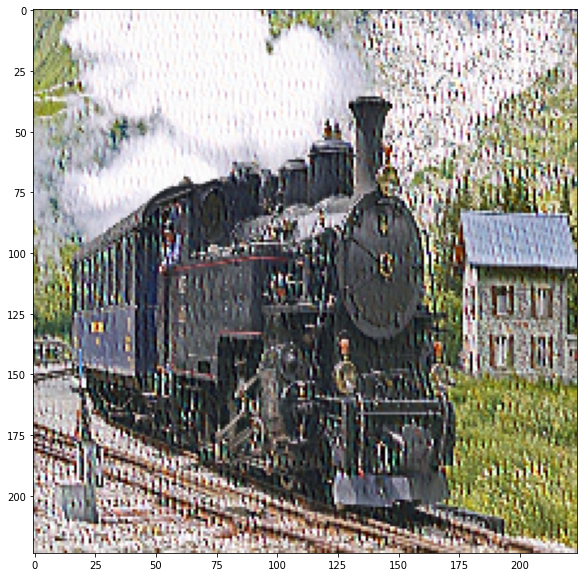

In [12]:
in_img = preprocess_input(test_imgs[0])[np.newaxis, :, :, :]
out_img = deep_dream(in_img, resnet, 'conv2_block1_1_conv', 10, 10000, 200)
decoded_img = deprocess_image(out_img[0])
plt.figure(figsize = (10,10))
plt.imshow(decoded_img[:,:,::-1])
plt.show()

At step: 0, loss: 0.013903852552175522
At step: 1, loss: 0.01689198799431324
At step: 2, loss: 0.020706892013549805
At step: 3, loss: 0.025535227730870247
At step: 4, loss: 0.03160937502980232
At step: 5, loss: 0.0384410098195076
At step: 6, loss: 0.04681636765599251
At step: 7, loss: 0.05842621624469757
At step: 8, loss: 0.07307393103837967
At step: 9, loss: 0.09341465681791306
At step: 10, loss: 0.12155986577272415
At step: 11, loss: 0.1606283336877823
At step: 12, loss: 0.21185116469860077
At step: 13, loss: 0.26459935307502747
At step: 14, loss: 0.2913671135902405
At step: 15, loss: 0.34476059675216675
At step: 16, loss: 0.3419606387615204
At step: 17, loss: 0.45161160826683044
At step: 18, loss: 0.5034688711166382
At step: 19, loss: 0.6336132884025574
At step: 20, loss: 0.7430274486541748
At step: 21, loss: 0.8129618763923645
At step: 22, loss: 0.6899504661560059
At step: 23, loss: 0.7531593441963196
At step: 24, loss: 1.0506788492202759
At step: 25, loss: 0.9896426796913147
At st

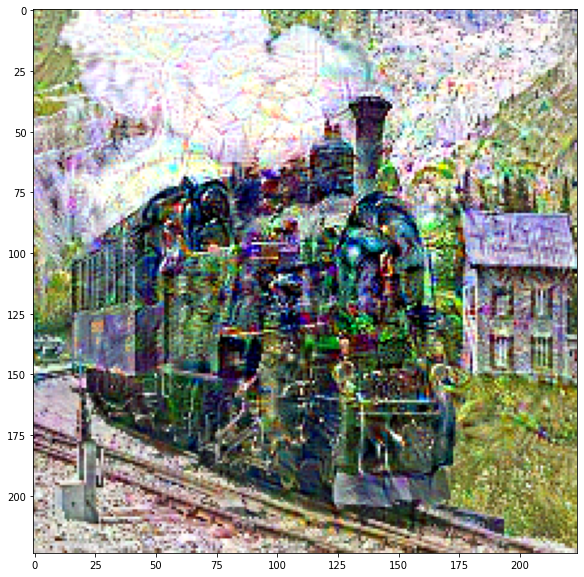

In [13]:
in_img = preprocess_input(test_imgs[0])[np.newaxis, :, :, :]
out_img = deep_dream(in_img, resnet, 'conv5_block3_3_conv', 187, 20000, 200)
decoded_img = deprocess_image(out_img[0])
plt.figure(figsize = (10,10))
plt.imshow(decoded_img[:,:,::-1])
plt.show()

### Úloha - Oklamanie siete (Adversarial example)

Aby sme si demonštrovali limitácie modelu, tak si teraz ukážeme ako je možné relatívne málo upraviť obrázok a oklamať tak sieť. Toto spravíme tak, že aplikujeme podobný postup ako v DeepDream časti, avšak maximalizovať budeme hodnotu klasifikácie pre nejakú triedu a minimalizovať budeme aktiváciu pre správnu klasifikáciu.

Dopíšte funkcia adversarial dream, tak aby upravila obrázok aby ho klasifikovala ako inú triedu ako predtým.

Pozn.: V prípade, že sa vyrábajú tzv. adversarial examples sa často krát pridáva do loss function člen, ktorý zabezpečí, že zmena obrázka je čo najmenšia, to však nás až tak netrápi.

In [14]:
def adversarial_dream(input_img, model):
  orig_class_id = int(np.argmax(model.predict(input_img)[0]))

  print(orig_class_id)
  model_input = model.input

  layer = model.layers[-1].output

  #loss = K.max(layer) - 2 * layer[:, orig_class_id] 
  loss = - layer[:, orig_class_id]
  grad = K.gradients(loss, model_input)[0]
  
  fetch_loss_grad = K.function([model_input], [loss, grad])

  r_loss = -1.0
  i = 0
  while r_loss < -0.1:
    out = fetch_loss_grad([input_img])
    i += 1
    r_loss = out[0]    

    r_grad = out[1]
    step = 1 / np.max(r_grad)
    #step = 1e5
    input_img += step * r_grad    
    print("At:{}, loss: {}, step_size: {}".format(i, r_loss, step))

  return input_img

Ak je funkcia správne implementovaná tento kód by mal zobraziť upravený obrázok. A po volaní predict by mala sieť vrátiť inú triedu.

820
At:1, loss: [-0.9962769], step_size: 66729.74990633961
At:2, loss: [-0.98830855], step_size: 16993.422661008
At:3, loss: [-0.972291], step_size: 4399.697700052039
At:4, loss: [-0.9529202], step_size: 2471.0226780624157
At:5, loss: [-0.9265958], step_size: 3108.9637071869547
At:6, loss: [-0.8707136], step_size: 1639.2601388248268
At:7, loss: [-0.8029768], step_size: 2974.4568192755273
At:8, loss: [-0.60665566], step_size: 1136.5719474706582
At:9, loss: [-0.45286274], step_size: 2098.5046799270453
At:10, loss: [-0.2197664], step_size: 2562.966461433849
At:11, loss: [-0.08669015], step_size: 3010.55765467712
0.94506633
[[('n03393912', 'freight_car', 0.94506633), ('n04310018', 'steam_locomotive', 0.040722124), ('n03895866', 'passenger_car', 0.008651103), ('n03272562', 'electric_locomotive', 0.0028678204), ('n03598930', 'jigsaw_puzzle', 0.00087402045)]]


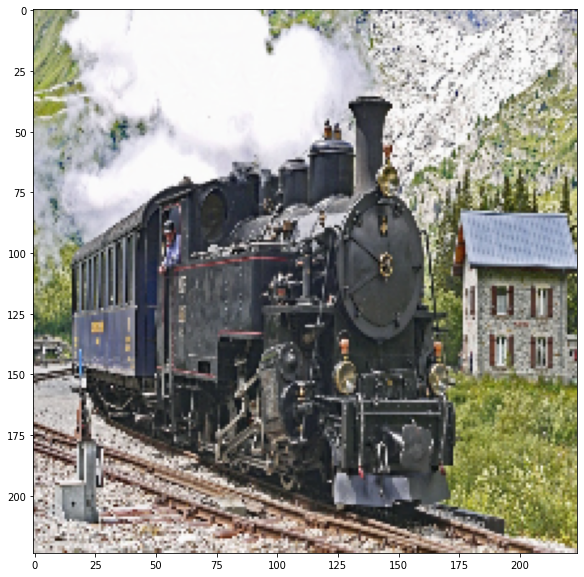

In [15]:
in_img = preprocess_input(test_imgs[0])[np.newaxis, :, :, :]
out_img = adversarial_dream(in_img, resnet)
prediction = resnet.predict(out_img)
print(np.max(prediction[0]))
print(decode_predictions(prediction))
decoded_img = deprocess_image(out_img[0])
plt.figure(figsize = (10,10))
plt.imshow(decoded_img[:,:,::-1])
plt.show()

Overíme si aj fungovanie po deprocesingu a processingu. Toto nemusí fungovať vždy úplne dobre, ale môžete sa s tým pohrať.

In [16]:
prediction = resnet.predict(preprocess_input(decoded_img)[np.newaxis, ...])
print(np.argmax(prediction[0]))
print(decode_predictions(prediction))

565
[[('n03393912', 'freight_car', 0.97357416), ('n04310018', 'steam_locomotive', 0.015930863), ('n03895866', 'passenger_car', 0.0058556027), ('n03272562', 'electric_locomotive', 0.0020197094), ('n03598930', 'jigsaw_puzzle', 0.0010206146)]]


### Úloha 3

Teraz dopíšte túto funkciu tak, aby generovala obrázok, ktorý sieť klasifikuje ako nami zvolenú triedu podľa ID zo [zoznamu](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Myslite na to, že zvolená trieda môže mať pre počiatočný obrázok veľmi malú pravdepodobnosť. Toto musíte vo funckii zohľadniť. 

In [17]:
def adversarial_dream_with_target(input_img, model, desired_class_id):
  orig_class_id = int(np.argmax(model.predict(input_img)[0]))

  print(orig_class_id)
  model_input = model.input

  layer = model.layers[-1].output

  prob_square = K.square(layer)
  loss = layer[:, desired_class_id]
  grad = K.gradients(loss, model_input)[0]
  
  fetch_loss_grad = K.function([model_input], [loss, grad])

  r_loss = -1.0
  i = 0
  while r_loss < 0.5:
    out = fetch_loss_grad([input_img])
    i += 1
    r_loss = out[0]    

    r_grad = out[1]
    step = 1 / np.max(r_grad)
    print("At:{}, loss: {}, step_size: {}".format(i, r_loss, step))
    input_img += step * r_grad

  return input_img

820
At:1, loss: [2.1304108e-06], step_size: 90833218.51854017
At:2, loss: [3.769423e-05], step_size: 4876686.256991191
At:3, loss: [0.00036538], step_size: 532164.0663467747
At:4, loss: [0.00243559], step_size: 104642.71128405766
At:5, loss: [0.01786931], step_size: 14524.096400408209
At:6, loss: [0.08097678], step_size: 4442.811282395692
At:7, loss: [0.29682168], step_size: 2604.052892688255
At:8, loss: [0.7101163], step_size: 2162.8493407854426
640
[[('n03717622', 'manhole_cover', 0.8787594), ('n02892201', 'brass', 0.03909049), ('n03598930', 'jigsaw_puzzle', 0.02364703), ('n04310018', 'steam_locomotive', 0.014964901), ('n03393912', 'freight_car', 0.008069541)]]


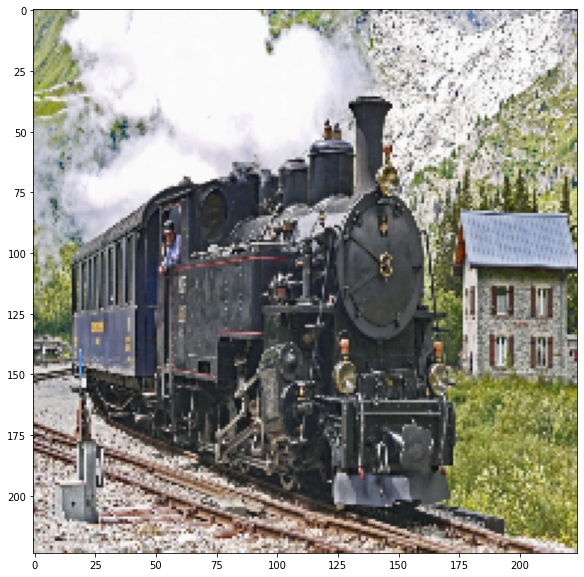

In [18]:
in_img = preprocess_input(test_imgs[0])[np.newaxis, :, :, :]
out_img = adversarial_dream_with_target(in_img, resnet, 640)
prediction = resnet.predict(out_img)
print(np.argmax(prediction[0]))
print(decode_predictions(prediction))
decoded_img = deprocess_image(out_img[0])
plt.figure(figsize = (10,10))
plt.imshow(decoded_img[:,:,::-1])
plt.show()

Opäť sa uistíme, či nám zaokrúhlovanie a cliping hodnôt neuškodí v zámere.

In [19]:
prediction = resnet.predict(preprocess_input(decoded_img)[np.newaxis, ...])
print(np.argmax(prediction[0]))
print(decode_predictions(prediction))

640
[[('n03717622', 'manhole_cover', 0.9131905), ('n02892201', 'brass', 0.03468704), ('n03598930', 'jigsaw_puzzle', 0.019419977), ('n03492542', 'hard_disc', 0.0052531664), ('n04310018', 'steam_locomotive', 0.0042515113)]]


Pre zaujímavosť si môžeme zobraziť aj rozdieľ obrázkov.

4.0
-6.0
float32


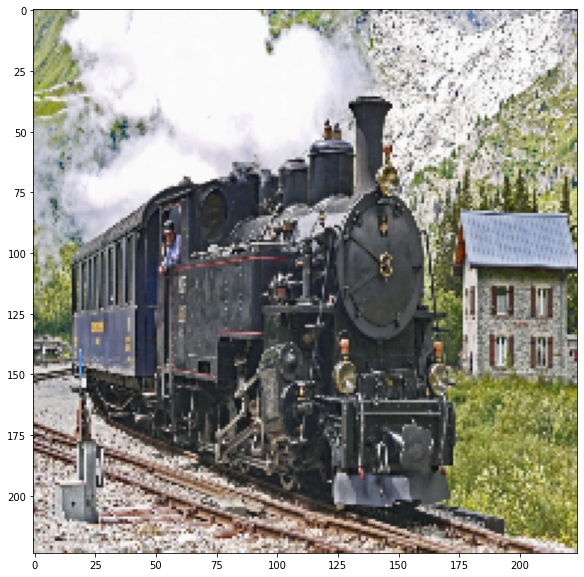

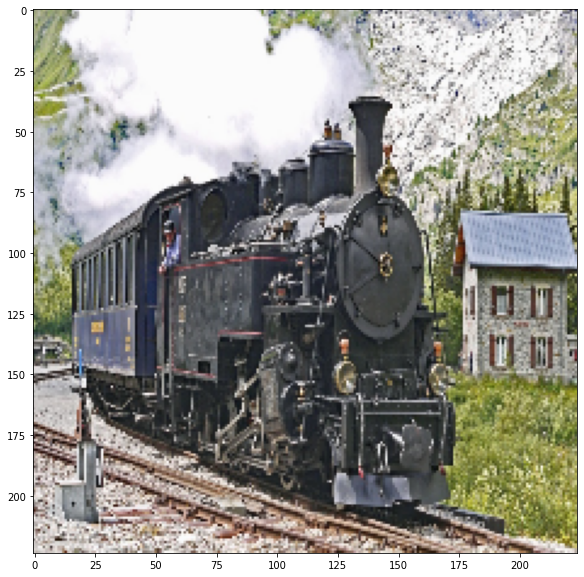

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


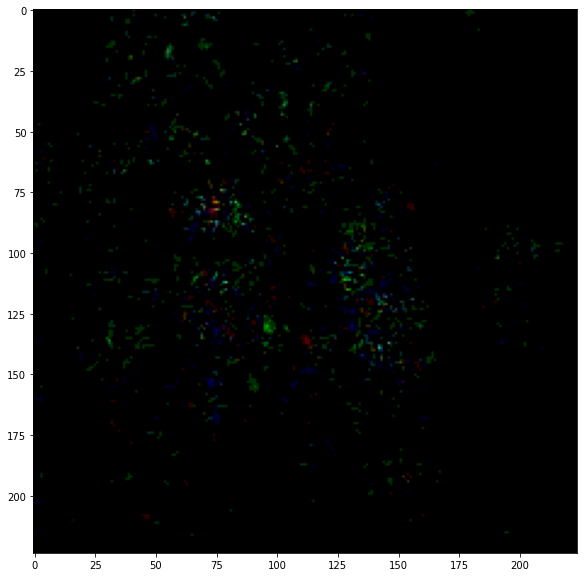

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


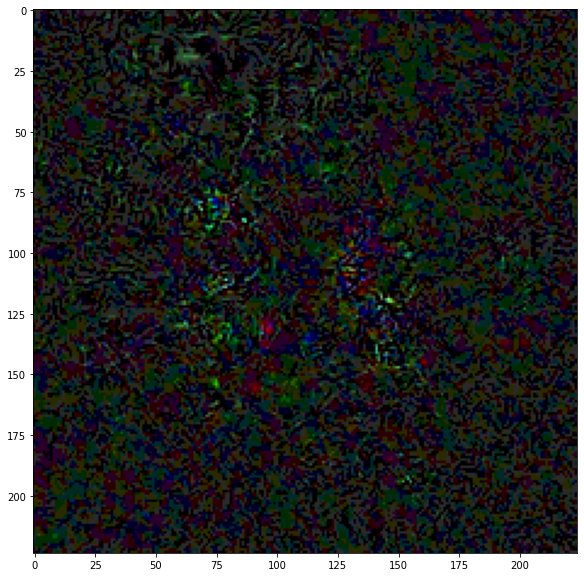

In [20]:
diff_img = decoded_img.astype(np.float32) - test_imgs[0].astype(np.float32)


print(np.max(diff_img))
print(np.min(diff_img))

diff_img /= np.max(np.abs(diff_img))

print(diff_img.dtype)

plt.figure(figsize = (10,10))
plt.imshow(decoded_img[:,:,::-1])
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(test_imgs[0][:,:,::-1])
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(diff_img[:,:,::-1])
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(-diff_img[:,:,::-1])
plt.show()

### Úloha 3 - FGSM

Doteraz sme upravovovali obrázok, tak že sme ku každému pixelu prirátali jeho gradient. Teda pre nejakú loss funkciu $L$ sme menili hodnotu pixelu $I_{i, j}$ nasledovne:

$$ I_{i, j}^{n + 1} = I_{i, j}^{n} + \eta \frac{\partial L}{\partial I_{i, j}}$$

Metóda FGSM spočíva v zmene tohto pravidla na:

$$ I_{i, j}^{n + 1} = I_{i, j}^{n} + sgn \left(\frac{\partial L}{\partial I_{i, j}} \right)$$,

kde $sgn$ je funkcia signum. Teda vždy budeme prirátavať k obrázku pixelu buď 0, 1, alebo -1. Takto vieme omnoho rýchlejšie meniť obrázok. Má to navyše výhodu, že ak máme pôvondý obrázok v uint8 a pri preprocessingu sme žiadny kanál neprenásobovali (tak ako v našom prípade keď len odčítame hodnoty), tak po tejto zmene máme stále valídny obrázok. T.j. po zavolaní deprocess a preprocess bude obrázok stále rovnaký.

Úlohu skúste naimplementovať. Môžete prepísať kód pre jednu z predchádzajúcich úloh.


In [21]:
def adversarial_fgsm(input_img, model):
  orig_class_id = int(np.argmax(model.predict(input_img)[0]))

  print(orig_class_id)
  model_input = model.input

  layer = model.layers[-1].output

  #loss = K.max(layer) - 2 * layer[:, orig_class_id] 
  loss = - layer[:, orig_class_id]
  grad = K.gradients(loss, model_input)[0]
  
  fetch_loss_grad = K.function([model_input], [loss, grad])

  r_loss = -1.0
  i = 0
  while r_loss < -0.1:
    out = fetch_loss_grad([input_img])
    i += 1
    r_loss = out[0]    

    r_grad = out[1]
    step = 1 / np.max(r_grad)
    #step = 1e5
    input_img += np.sign(r_grad)
    print("At:{}, loss: {}, step_size: {}".format(i, r_loss, step))

  return input_img

820
At:1, loss: [-0.9962769], step_size: 66729.74990633961
At:2, loss: [-0.30099636], step_size: 1540.7637981246842
At:3, loss: [-0.00144748], step_size: 178361.64802408367
0.9483992
[[('n03393912', 'freight_car', 0.9483992), ('n03598930', 'jigsaw_puzzle', 0.050084114), ('n03492542', 'hard_disc', 0.00042377654), ('n02892201', 'brass', 0.00041454245), ('n03717622', 'manhole_cover', 5.913478e-05)]]


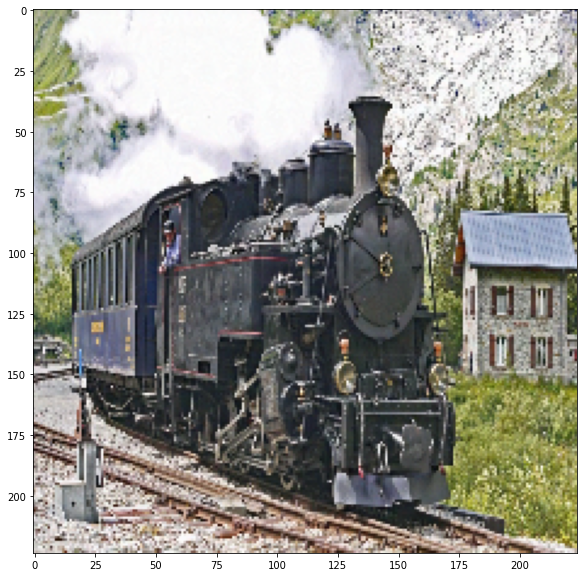

In [22]:
in_img = preprocess_input(test_imgs[0])[np.newaxis, :, :, :]
out_img = adversarial_fgsm(in_img, resnet)
prediction = resnet.predict(out_img)
print(np.max(prediction[0]))
print(decode_predictions(prediction))
decoded_img = deprocess_image(out_img[0])
plt.figure(figsize = (10,10))
plt.imshow(decoded_img[:,:,::-1])
plt.show()